# Notatnik wzorowany na https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.ipynb

In [1]:
!pip install torchinfo

In [2]:
import os
#set workdir
os.chdir("/content/drive/MyDrive/RiverSemanticSegmentation/")

In [3]:
#imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from dataloader import Dataset
from torchinfo import summary
import time
import copy

from tqdm import tqdm


In [4]:
#training parameters in neptune format
PARAMS = {
    "input_size": 416,
    "output_size": 208,
    "model": "vgg_unet_ks",
    "learning_rate": 0.001,
    "batch_size": 16,
    'epochs': 1000,
    'patience': 20,
    "train_dataset_size": -1,
    "test_dataset_size": -1,
    "n_classes": 2,
    'image_preload': False
}

In [5]:
#neptune installation and initialization
!pip install neptune-client
import neptune
neptune.init(project_qualified_name='radek/pth1',
             api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYmY4YjQ3YjEtNmY5My00MDc2LWI4NzAtMWE5MmUwZjQ1NDE2In0=',
             )
neptune.create_experiment(params=PARAMS)


https://ui.neptune.ai/radek/pth1/e/PTH1-106


Experiment(PTH1-106)

In [6]:
#dataset configuration
dataset_dir = os.path.normpath("/content/drive/MyDrive/SemanticSegmentationV2/dataset/")
x_train_dir = os.path.join(dataset_dir,"x_train")
y_train_dir = os.path.join(dataset_dir,"y_train")
x_test_dir = os.path.join(dataset_dir,"x_test")
y_test_dir = os.path.join(dataset_dir,"y_test")

train_set = Dataset(x_train_dir, y_train_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS["n_classes"], count=PARAMS["train_dataset_size"])
test_set = Dataset(x_test_dir, y_test_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS["n_classes"], count=PARAMS["test_dataset_size"])

batch_size = PARAMS['batch_size']
dataloaders = {
    'train': DataLoader(train_set, batch_size=PARAMS['batch_size'], shuffle=True, num_workers=0),
    'val': DataLoader(test_set, batch_size=PARAMS['batch_size'], shuffle=True, num_workers=0)
}

In [7]:
# load images - useful if you want to save some time by preloading images (very time-consuming) when 
# the model is still not fuctional and cant run standard training.
if PARAMS['image_preload']:
  for phase in dataloaders:
    for inputs, labels in tqdm(dataloaders[phase]):
      pass


In [8]:
#model loading
if PARAMS['model'] == "simple":
  from models.simple import Simple
  model = Simple()
elif PARAMS['model'] == "vgg_unet":
  from models.vgg_unet import VggUnet
  model = VggUnet()
elif PARAMS['model'] == "vgg_unet_ks":
  from models.vgg_unet_ks import VggUnetKs
  model = VggUnetKs()
elif PARAMS['model'] == "unet":
  from models.unet import UNet
  model = UNet()
elif PARAMS['model'] == "vgg_deconvnet":
  from models.vgg16_deconvnet import VggDeconvNet
  model = VggDeconvNet()

In [9]:
#model structure preview
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
summary(model, input_size=(PARAMS['batch_size'], 3, PARAMS['input_size'], PARAMS['input_size']))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-1                       [16, 64, 416, 416]        1,792
|    └─ReLU: 2-2                         [16, 64, 416, 416]        --
|    └─Conv2d: 2-3                       [16, 64, 416, 416]        36,928
|    └─ReLU: 2-4                         [16, 64, 416, 416]        --
|    └─MaxPool2d: 2-5                    [16, 64, 208, 208]        --
|    └─Conv2d: 2-6                       [16, 128, 208, 208]       73,856
|    └─ReLU: 2-7                         [16, 128, 208, 208]       --
|    └─Conv2d: 2-8                       [16, 128, 208, 208]       147,584
|    └─ReLU: 2-9                         [16, 128, 208, 208]       --
|    └─MaxPool2d: 2-10                   [16, 128, 104, 104]       --
|    └─Conv2d: 2-11                      [16, 256, 104, 104]       295,168
|    └─ReLU: 2-12                        [16, 256, 104, 104]    

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-1                       [16, 64, 416, 416]        1,792
|    └─ReLU: 2-2                         [16, 64, 416, 416]        --
|    └─Conv2d: 2-3                       [16, 64, 416, 416]        36,928
|    └─ReLU: 2-4                         [16, 64, 416, 416]        --
|    └─MaxPool2d: 2-5                    [16, 64, 208, 208]        --
|    └─Conv2d: 2-6                       [16, 128, 208, 208]       73,856
|    └─ReLU: 2-7                         [16, 128, 208, 208]       --
|    └─Conv2d: 2-8                       [16, 128, 208, 208]       147,584
|    └─ReLU: 2-9                         [16, 128, 208, 208]       --
|    └─MaxPool2d: 2-10                   [16, 128, 104, 104]       --
|    └─Conv2d: 2-11                      [16, 256, 104, 104]       295,168
|    └─ReLU: 2-12                        [16, 256, 104, 104]    

In [10]:
from collections import defaultdict
import torch.nn.functional as F
SMOOTH = 1e-6
def iou_metric(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs[:,1,:,:]  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels[:,1,:,:]
    intersection = (outputs * labels).sum(2).sum(1)  # Will be zero if Truth=0 or Prediction=0
    union = (outputs + labels).sum(2).sum(1) - intersection  # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    return iou.mean()
    

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    pred = torch.sigmoid(pred)
    bce = F.binary_cross_entropy(pred, target)
    pred = torch.round(pred)
    dice = dice_loss(pred, target)
    loss = bce# * bce_weight + dice * (1 - bce_weight)
    iou = iou_metric(pred, target)
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    metrics['iou'] += iou.data.cpu().numpy() * target.size(0)
    return loss

def print_metrics(metrics, epoch_samples, phase):   
    print(epoch_samples) 
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        neptune.log_metric(phase+"_"+k, metrics[k] / epoch_samples) #log
    print("{}: {}".format(phase, ", ".join(outputs)))    



In [11]:
#training loop
def train_model(model, dataloaders, optimizer, device, num_epochs=25, patience=-1):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    no_improvement = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val':
              if epoch_loss < best_loss:
                no_improvement = 0
                print("Accuracy improvement achieved - saving best model.")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
              else:
                no_improvement += 1
                print("No accuracy improvement since {}/{} epochs.".format(no_improvement,patience))
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        if patience >= 0 and no_improvement > patience:
          break
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
#model training
optimizer_ft = optim.Adam(model.parameters(), lr=PARAMS['learning_rate'])
model = train_model(model, dataloaders, optimizer_ft, device, num_epochs=PARAMS['epochs'], patience=PARAMS['patience'])

  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 0/999
----------
LR 0.001


100%|██████████| 151/151 [1:24:52<00:00, 33.73s/it]


2412


  0%|          | 0/36 [00:00<?, ?it/s]

train: bce: 0.180974, dice: 0.180614, loss: 0.180974, iou: 0.556258


100%|██████████| 36/36 [20:06<00:00, 33.52s/it]


570


  0%|          | 0/151 [00:00<?, ?it/s]

val: bce: 0.142560, dice: 0.153255, loss: 0.142560, iou: 0.601120
Accuracy improvement achieved - saving best model.
105m 3s
Epoch 1/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.089479, dice: 0.140056, loss: 0.089479, iou: 0.632607


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.204671, dice: 0.122798, loss: 0.204671, iou: 0.664971
No accuracy improvement since 1/20 epochs.
1m 38s
Epoch 2/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.057483, dice: 0.100462, loss: 0.057483, iou: 0.720283


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.056555, dice: 0.092502, loss: 0.056555, iou: 0.738652
Accuracy improvement achieved - saving best model.
1m 39s
Epoch 3/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.057930, dice: 0.097891, loss: 0.057930, iou: 0.726503


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.087952, dice: 0.083399, loss: 0.087952, iou: 0.758503
No accuracy improvement since 1/20 epochs.
1m 38s
Epoch 4/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.049339, dice: 0.087632, loss: 0.049339, iou: 0.750970


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.170155, dice: 0.104953, loss: 0.170155, iou: 0.704634
No accuracy improvement since 2/20 epochs.
1m 38s
Epoch 5/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.046067, dice: 0.082333, loss: 0.046067, iou: 0.763415


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.251085, dice: 0.083748, loss: 0.251085, iou: 0.758816
No accuracy improvement since 3/20 epochs.
1m 39s
Epoch 6/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.039695, dice: 0.074256, loss: 0.039695, iou: 0.783510


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.105442, dice: 0.079404, loss: 0.105442, iou: 0.767750
No accuracy improvement since 4/20 epochs.
1m 38s
Epoch 7/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.043538, dice: 0.079488, loss: 0.043538, iou: 0.770460


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.079318, dice: 0.074518, loss: 0.079318, iou: 0.779863
No accuracy improvement since 5/20 epochs.
1m 39s
Epoch 8/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.036688, dice: 0.068851, loss: 0.036688, iou: 0.796449


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.061798, dice: 0.065641, loss: 0.061798, iou: 0.802030
No accuracy improvement since 6/20 epochs.
1m 39s
Epoch 9/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.033346, dice: 0.065226, loss: 0.033346, iou: 0.806650


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.085000, dice: 0.068622, loss: 0.085000, iou: 0.794785
No accuracy improvement since 7/20 epochs.
1m 38s
Epoch 10/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.033781, dice: 0.064737, loss: 0.033781, iou: 0.806875


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.058907, dice: 0.060602, loss: 0.058907, iou: 0.814863
No accuracy improvement since 8/20 epochs.
1m 39s
Epoch 11/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.032214, dice: 0.063055, loss: 0.032214, iou: 0.811449


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.095291, dice: 0.064440, loss: 0.095291, iou: 0.804810
No accuracy improvement since 9/20 epochs.
1m 39s
Epoch 12/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.031201, dice: 0.061317, loss: 0.031201, iou: 0.816122


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.061583, dice: 0.062809, loss: 0.061583, iou: 0.808428
No accuracy improvement since 10/20 epochs.
1m 38s
Epoch 13/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.030533, dice: 0.060727, loss: 0.030533, iou: 0.817493


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.072159, dice: 0.061930, loss: 0.072159, iou: 0.811954
No accuracy improvement since 11/20 epochs.
1m 39s
Epoch 14/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.033194, dice: 0.064625, loss: 0.033194, iou: 0.807909


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.191308, dice: 0.086288, loss: 0.191308, iou: 0.750707
No accuracy improvement since 12/20 epochs.
1m 39s
Epoch 15/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.054680, dice: 0.091769, loss: 0.054680, iou: 0.743378


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.384313, dice: 0.092056, loss: 0.384313, iou: 0.737795
No accuracy improvement since 13/20 epochs.
1m 38s
Epoch 16/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.045823, dice: 0.081940, loss: 0.045823, iou: 0.765942


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.086934, dice: 0.120410, loss: 0.086934, iou: 0.672051
No accuracy improvement since 14/20 epochs.
1m 38s
Epoch 17/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.052969, dice: 0.089997, loss: 0.052969, iou: 0.747561


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.040650, dice: 0.066018, loss: 0.040650, iou: 0.802308
Accuracy improvement achieved - saving best model.
1m 38s
Epoch 18/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.042396, dice: 0.077962, loss: 0.042396, iou: 0.775151


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.085339, dice: 0.074967, loss: 0.085339, iou: 0.776541
No accuracy improvement since 1/20 epochs.
1m 38s
Epoch 19/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.032559, dice: 0.063098, loss: 0.032559, iou: 0.811686


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.036034, dice: 0.059731, loss: 0.036034, iou: 0.818450
Accuracy improvement achieved - saving best model.
1m 38s
Epoch 20/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.029984, dice: 0.059439, loss: 0.029984, iou: 0.821126


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.052314, dice: 0.059770, loss: 0.052314, iou: 0.818230
No accuracy improvement since 1/20 epochs.
1m 37s
Epoch 21/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.029199, dice: 0.057777, loss: 0.029199, iou: 0.824826


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.120958, dice: 0.061611, loss: 0.120958, iou: 0.812767
No accuracy improvement since 2/20 epochs.
1m 38s
Epoch 22/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.027487, dice: 0.054878, loss: 0.027487, iou: 0.832674


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.041851, dice: 0.053152, loss: 0.041851, iou: 0.834686
No accuracy improvement since 3/20 epochs.
1m 38s
Epoch 23/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.027000, dice: 0.054293, loss: 0.027000, iou: 0.834442


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.051349, dice: 0.054946, loss: 0.051349, iou: 0.830790
No accuracy improvement since 4/20 epochs.
1m 38s
Epoch 24/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.026207, dice: 0.052277, loss: 0.026207, iou: 0.838848


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.043891, dice: 0.055190, loss: 0.043891, iou: 0.827957
No accuracy improvement since 5/20 epochs.
1m 38s
Epoch 25/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.025803, dice: 0.051830, loss: 0.025803, iou: 0.840271


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.042955, dice: 0.056233, loss: 0.042955, iou: 0.829210
No accuracy improvement since 6/20 epochs.
1m 38s
Epoch 26/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.024652, dice: 0.049806, loss: 0.024652, iou: 0.845611


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.042292, dice: 0.051116, loss: 0.042292, iou: 0.840096
No accuracy improvement since 7/20 epochs.
1m 38s
Epoch 27/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.024867, dice: 0.050202, loss: 0.024867, iou: 0.844610


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.057696, dice: 0.056678, loss: 0.057696, iou: 0.826375
No accuracy improvement since 8/20 epochs.
1m 38s
Epoch 28/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.037255, dice: 0.067755, loss: 0.037255, iou: 0.800905


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.067773, dice: 0.073099, loss: 0.067773, iou: 0.782168
No accuracy improvement since 9/20 epochs.
1m 38s
Epoch 29/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.032444, dice: 0.062686, loss: 0.032444, iou: 0.812259


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.242549, dice: 0.062016, loss: 0.242549, iou: 0.818849
No accuracy improvement since 10/20 epochs.
1m 38s
Epoch 30/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.026430, dice: 0.052608, loss: 0.026430, iou: 0.838312


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.077992, dice: 0.055257, loss: 0.077992, iou: 0.831649
No accuracy improvement since 11/20 epochs.
1m 39s
Epoch 31/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.024617, dice: 0.049321, loss: 0.024617, iou: 0.846651


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.037409, dice: 0.050777, loss: 0.037409, iou: 0.840917
No accuracy improvement since 12/20 epochs.
1m 38s
Epoch 32/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.023603, dice: 0.047775, loss: 0.023603, iou: 0.850416


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.043089, dice: 0.050537, loss: 0.043089, iou: 0.841508
No accuracy improvement since 13/20 epochs.
1m 37s
Epoch 33/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.023409, dice: 0.047372, loss: 0.023409, iou: 0.851871


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.031983, dice: 0.049381, loss: 0.031983, iou: 0.845357
Accuracy improvement achieved - saving best model.
1m 38s
Epoch 34/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.022738, dice: 0.046268, loss: 0.022738, iou: 0.854757


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.034281, dice: 0.056136, loss: 0.034281, iou: 0.828947
No accuracy improvement since 1/20 epochs.
1m 38s
Epoch 35/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.022394, dice: 0.045538, loss: 0.022394, iou: 0.856819


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.031771, dice: 0.049910, loss: 0.031771, iou: 0.842908
Accuracy improvement achieved - saving best model.
1m 38s
Epoch 36/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.022012, dice: 0.044477, loss: 0.022012, iou: 0.859248


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.041551, dice: 0.052806, loss: 0.041551, iou: 0.835251
No accuracy improvement since 1/20 epochs.
1m 38s
Epoch 37/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.021859, dice: 0.044439, loss: 0.021859, iou: 0.859373


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.047608, dice: 0.050660, loss: 0.047608, iou: 0.844368
No accuracy improvement since 2/20 epochs.
1m 38s
Epoch 38/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.021322, dice: 0.043451, loss: 0.021322, iou: 0.862275


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.030094, dice: 0.048213, loss: 0.030094, iou: 0.847958
Accuracy improvement achieved - saving best model.
1m 38s
Epoch 39/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.021158, dice: 0.043058, loss: 0.021158, iou: 0.862939


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.032448, dice: 0.051430, loss: 0.032448, iou: 0.839925
No accuracy improvement since 1/20 epochs.
1m 38s
Epoch 40/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.020583, dice: 0.042130, loss: 0.020583, iou: 0.866119


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.043268, dice: 0.050545, loss: 0.043268, iou: 0.843801
No accuracy improvement since 2/20 epochs.
1m 37s
Epoch 41/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.020972, dice: 0.042742, loss: 0.020972, iou: 0.863932


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.030720, dice: 0.049954, loss: 0.030720, iou: 0.843129
No accuracy improvement since 3/20 epochs.
1m 35s
Epoch 42/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.029180, dice: 0.052900, loss: 0.029180, iou: 0.840025


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.401679, dice: 0.242575, loss: 0.401679, iou: 0.441843
No accuracy improvement since 4/20 epochs.
1m 35s
Epoch 43/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.058363, dice: 0.099846, loss: 0.058363, iou: 0.724161


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.096582, dice: 0.072670, loss: 0.096582, iou: 0.784000
No accuracy improvement since 5/20 epochs.
1m 38s
Epoch 44/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.052178, dice: 0.088979, loss: 0.052178, iou: 0.749408


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.039527, dice: 0.065271, loss: 0.039527, iou: 0.804913
No accuracy improvement since 6/20 epochs.
1m 38s
Epoch 45/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.031538, dice: 0.061142, loss: 0.031538, iou: 0.815757


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.051931, dice: 0.058792, loss: 0.051931, iou: 0.820760
No accuracy improvement since 7/20 epochs.
1m 38s
Epoch 46/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.026175, dice: 0.052653, loss: 0.026175, iou: 0.837899


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.051572, dice: 0.054560, loss: 0.051572, iou: 0.832189
No accuracy improvement since 8/20 epochs.
1m 38s
Epoch 47/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.023913, dice: 0.048646, loss: 0.023913, iou: 0.848581


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.041523, dice: 0.053173, loss: 0.041523, iou: 0.835152
No accuracy improvement since 9/20 epochs.
1m 38s
Epoch 48/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.022472, dice: 0.045658, loss: 0.022472, iou: 0.855652


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.040100, dice: 0.050423, loss: 0.040100, iou: 0.842333
No accuracy improvement since 10/20 epochs.
1m 38s
Epoch 49/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.021438, dice: 0.043527, loss: 0.021438, iou: 0.861858


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.094058, dice: 0.053032, loss: 0.094058, iou: 0.838914
No accuracy improvement since 11/20 epochs.
1m 38s
Epoch 50/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.020810, dice: 0.042580, loss: 0.020810, iou: 0.864367


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.044311, dice: 0.049391, loss: 0.044311, iou: 0.845094
No accuracy improvement since 12/20 epochs.
1m 38s
Epoch 51/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.020482, dice: 0.041493, loss: 0.020482, iou: 0.867081


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.134634, dice: 0.054102, loss: 0.134634, iou: 0.832348
No accuracy improvement since 13/20 epochs.
1m 38s
Epoch 52/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.020579, dice: 0.042235, loss: 0.020579, iou: 0.865539


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.125887, dice: 0.054221, loss: 0.125887, iou: 0.833708
No accuracy improvement since 14/20 epochs.
1m 39s
Epoch 53/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.019810, dice: 0.040367, loss: 0.019810, iou: 0.869924


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.037783, dice: 0.048716, loss: 0.037783, iou: 0.846542
No accuracy improvement since 15/20 epochs.
1m 38s
Epoch 54/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.019351, dice: 0.039157, loss: 0.019351, iou: 0.873324


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.044607, dice: 0.048926, loss: 0.044607, iou: 0.846423
No accuracy improvement since 16/20 epochs.
1m 38s
Epoch 55/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.019230, dice: 0.039276, loss: 0.019230, iou: 0.873064


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.219732, dice: 0.054793, loss: 0.219732, iou: 0.835418
No accuracy improvement since 17/20 epochs.
1m 38s
Epoch 56/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.019185, dice: 0.038863, loss: 0.019185, iou: 0.874547


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.043071, dice: 0.052279, loss: 0.043071, iou: 0.836402
No accuracy improvement since 18/20 epochs.
1m 39s
Epoch 57/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.018765, dice: 0.037737, loss: 0.018765, iou: 0.877349


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.043725, dice: 0.047942, loss: 0.043725, iou: 0.848083
No accuracy improvement since 19/20 epochs.
1m 38s
Epoch 58/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.018372, dice: 0.037433, loss: 0.018372, iou: 0.878444


  0%|          | 0/151 [00:00<?, ?it/s]

570
val: bce: 0.066170, dice: 0.049141, loss: 0.066170, iou: 0.847936
No accuracy improvement since 20/20 epochs.
1m 38s
Epoch 59/999
----------
LR 0.001


  0%|          | 0/36 [00:00<?, ?it/s]

2412
train: bce: 0.018083, dice: 0.036882, loss: 0.018083, iou: 0.879777


100%|██████████| 36/36 [00:17<00:00,  2.00it/s]

570
val: bce: 0.032943, dice: 0.047637, loss: 0.032943, iou: 0.849480
No accuracy improvement since 21/20 epochs.
1m 38s
Best val loss: 0.030094


In [13]:
# save weights
torch.save(model.state_dict(),"state_dict.pth")

In [14]:
# load weights
model.load_state_dict(torch.load("state_dict.pth", map_location="cpu"))

<All keys matched successfully>

In [15]:
# denormalization function
from torchvision import transforms
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

def reverse_transform(inp):
    print(inp.shape)
    inp = inv_normalize(inp)
    inp = inp.numpy()
    inp = np.swapaxes(inp, 1, 3)
    inp = np.swapaxes(inp, 1, 2)
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp
def labels2mask(labels):
    return labels[:,1,:,:]

In [16]:
# helper function to plot input, ground truth and predict images in grid
import matplotlib.pyplot as plt
def plot_side_by_side(rgb,ground_truth,predict):
  assert rgb.shape[0] == ground_truth.shape[0] == predict.shape[0]
  batch_size = rgb.shape[0]
  fig, axs = plt.subplots(batch_size, 3, figsize=(30,50))
  for i in range(batch_size):
    axs[i, 0].imshow(rgb[i])
    axs[i, 1].imshow(ground_truth[i])
    axs[i, 2].imshow(predict[i])

torch.Size([3, 3, 416, 416])
0.0
0.0
0.0
0.0
0.0
0.0


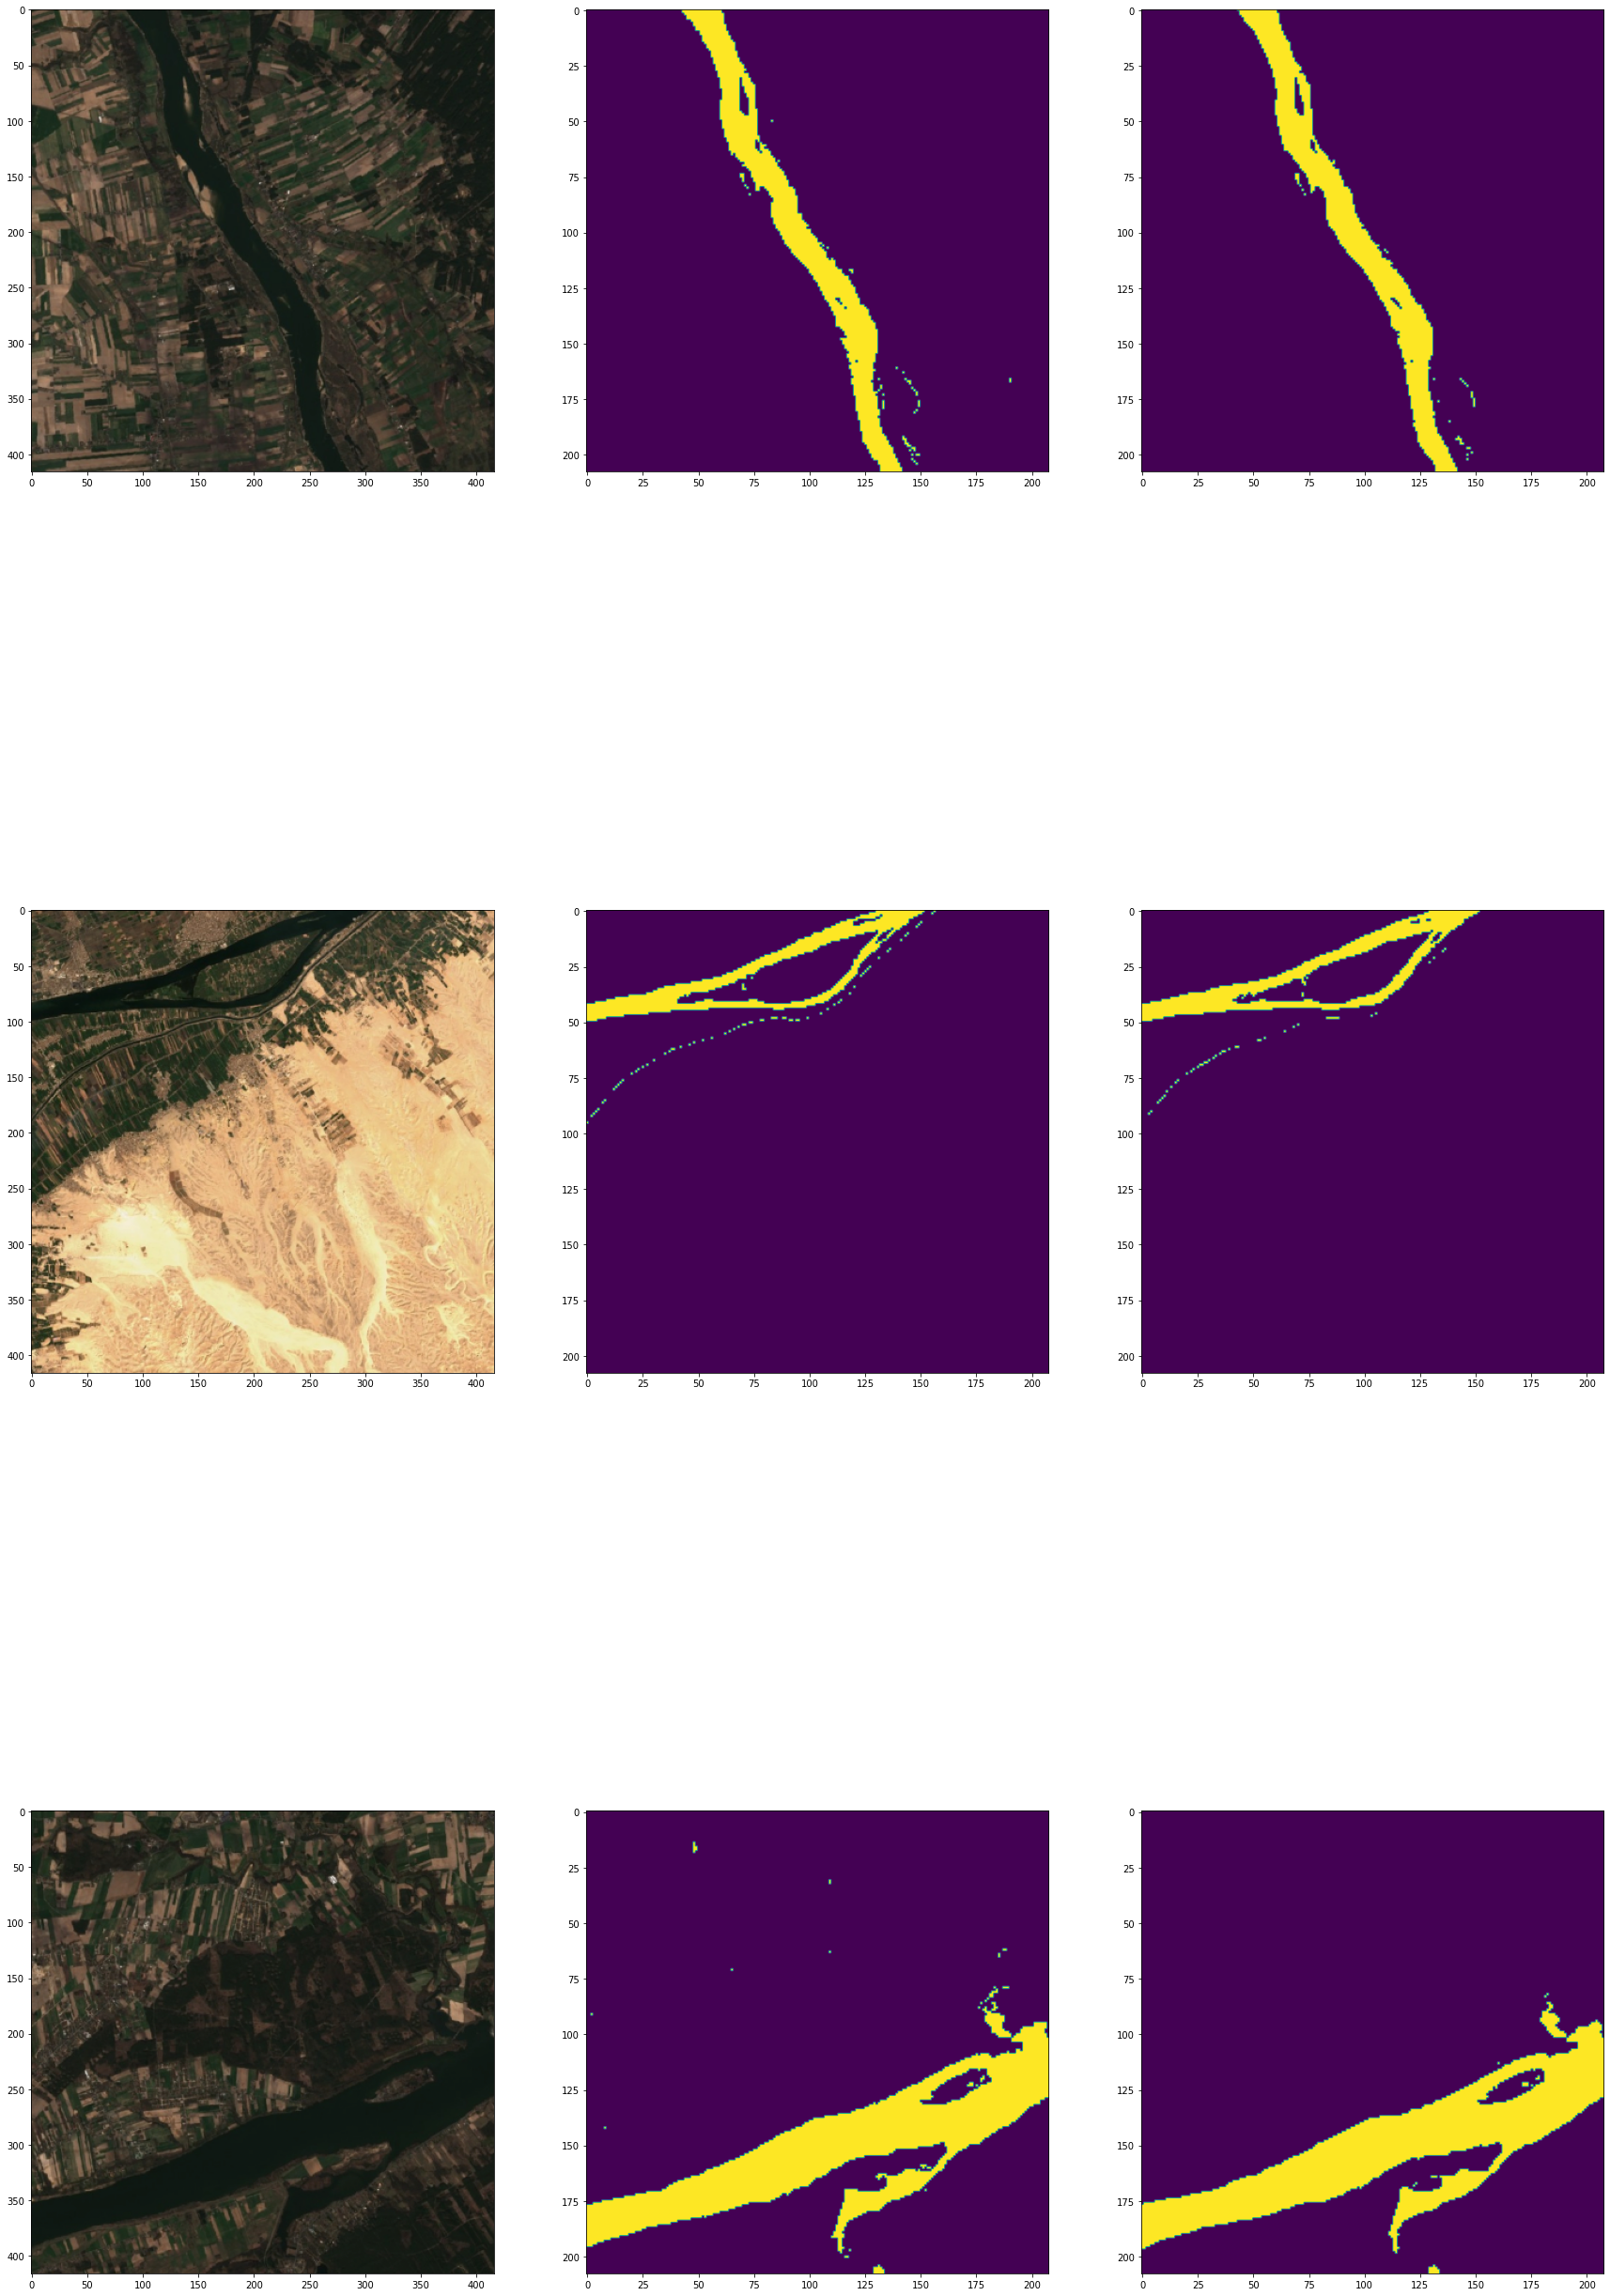

In [17]:
# visualize example segmentation
import math
model.eval()   # Set model to evaluate mode
test_dataset = Dataset(x_test_dir, y_test_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS['n_classes'])
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=True, num_workers=0)
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

labels = labels.data.cpu().numpy()
pred = model(inputs)
pred = torch.sigmoid(pred)
pred = torch.round(pred)
pred = pred.data.cpu().numpy()
inputs = inputs.data.cpu()

# dataloader return normalized input image, so we have to denormalize before viewing
input_images = reverse_transform(inputs)
# target and predict mask are single channel, so squeeze
target_masks = labels2mask(labels)
pred = labels2mask(pred)
# use helper function to plot
plot_side_by_side(input_images, target_masks, pred)

In [18]:
#evaluate model
test_dataset = Dataset(x_test_dir, y_test_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS['n_classes'])
test_loader = DataLoader(test_dataset, batch_size=PARAMS["batch_size"], shuffle=True, num_workers=0)
intersection=0
union=0
for inputs, labels in tqdm(test_loader):
  inputs = inputs.to(device)
  labels = labels.to(device)
  labels = labels.data.cpu().numpy()
  pred = model(inputs)
  pred = torch.sigmoid(pred)
  pred = torch.round(pred)
  pred = pred.data.cpu().numpy()
  target = labels[:,1,:,:]
  predict = pred[:,1,:,:]
  temp = (target * predict).sum()
  intersection+=temp
  union+=((target + predict).sum() - temp)
iou = intersection/union
print("IoU: {}".format(iou))
neptune.log_metric("total_iou",iou)

100%|██████████| 36/36 [00:19<00:00,  1.89it/s]


IoU: 0.8930192018664161


In [19]:
# update neptune status
neptune.stop()